In [1]:
!pip install transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 33.2 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login

login()

In [13]:
import numpy as np
import pandas as pd
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import random

In [4]:
model_name = "meta-llama/Llama-2-13b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model in 4-bit precision
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype="auto"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Add data

In [5]:
file_path = r"/content/all_data.csv"
data = pd.read_csv(file_path)

<ipython-input-5-08146613f25a>:2: DtypeWarning: Columns (8,9,31,32,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [6]:
tasks = ['Free recall', 'Lexical decision', 'Cued recall', 'Single recognition', 'Associative recognition']

In [7]:
task_data = {task: data[data['condition'] == task] for task in tasks}

In [8]:
cleaned_tasks = {}

cleaned_tasks['Free recall'] = task_data['Free recall'][['subject', 'trial', 'resp.string','stim.string.left']].dropna()
cleaned_tasks['Lexical decision'] = task_data['Lexical decision'][['subject', 'stim.string.left', 'resp', 'rt']].dropna()
cleaned_tasks['Cued recall'] = task_data['Cued recall'][['subject', 'trial', 'stim.string.left', 'resp.string']].dropna()
cleaned_tasks['Single recognition'] = task_data['Single recognition'][['subject', 'stim.string.left', 'resp']].dropna()
cleaned_tasks['Associative recognition'] = task_data['Associative recognition'][['subject', 'stim.string.left', 'stim.string.right', 'resp']].dropna()

- Single Recognition


In [10]:
single_recognition_data = cleaned_tasks['Lexical decision']

In [11]:
single_recognition_data.shape

(27121, 4)

In [12]:
single_recognition_data.head()

,subject,stim.string.left,resp,rt
53,2,APARTMENT,1,0.94
54,2,RASSING,0,1.77
55,2,CONWRESHLY,0,2.51
56,2,MISSING,1,0.58
57,2,CRITHERS,0,1.57


I will need study phase as single recognition is a memory task where participants are shown a single item and asked whether it was presented during a previous study phase.

- Study phase - Old items studied
- Test phase - some old items(1) and some new(0)


In [14]:
def generate_study_phase_prompt(study_items):
    study_prompt = (
        "Study the following list of words carefully. These words are important, as you will be tested on them later:\n\n"
        + "\n".join(f"- {item}" for item in study_items) +
        "\n\nTake your time to study these words."
    )
    return study_prompt

In [47]:
def generate_test_phase_prompt(stimulus):
    test_prompt = (
        f"Now, Decide whether the following word was in the previously studied list:\n"
        f"Word: {stimulus}\n"
        "Respond with '1' if it is an old word (present in the study phase) or '0' if it is new. Your Output :"
    )
    return test_prompt

In [64]:
def generate_combined_prompt(study_items: list, test_word: str):

    prompt = (
        "This is a list of words that you have to remember-\nSTUDY LIST:"
        + "\n".join(f"- {item}" for item in study_items) +
        f"\nNow, decide whether the following word was in the STUDY LIST:\nWord: '{test_word}'\n"
        "Respond with '1' if the word is present in the study list or '0' if it is not. Model Output: "
    )
    return prompt

In [36]:
def ask_llm_v2(prompt, tokenizer, model):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.2,
        top_p=0.95,
        eos_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True).strip()
    return response

In [63]:
def get_model_responses_single_recognition(study_items, test_items, tokenizer, model):

    # Study phase
    #study_prompt = generate_study_phase_prompt(study_items)
    #print("--Study Phase Prompt--")
    #print(study_prompt)
    #ask_llm_v2(study_prompt, tokenizer, model)

    # Test phase
    model_responses = []
    for stimulus in test_items:
        test_prompt = generate_test_phase_prompt(stimulus)
        print("--Test Phase Prompt--")
        #print(study_prompt+test_prompt)
        comb_prompt = generate_combined_prompt(study_items, stimulus)
        response = ask_llm_v2(comb_prompt, tokenizer, model)
        print("--Model Response--")
        print(response)
        response_cleaned = input("\n###########Enter Manually: ")
        model_responses.append(response_cleaned)

    return model_responses

In [59]:
new_single_recognition_data = single_recognition_data.sample(15)

In [69]:
new_single_recognition_data.head()

,subject,stim.string.left,resp,rt
38386,176,FOCUS,1,0.68
101010,456,ONX,0,0.60
19122,87,CONCHRINTION,0,1.96
58657,267,PARAGRAPH,1,1.03
68576,311,POOTS,0,1.05


In [60]:
study_items = random.sample(new_single_recognition_data['stim.string.left'].dropna().unique().tolist(), 10)
study_items

['OWBAN',
 'MAS',
 'RULER',
 'POOTS',
 'REROOF',
 'PARAGRAPH',
 'POUTES',
 'PLAYS',
 'GUARD',
 'FOCUS']

In [61]:
test_items = random.sample(new_single_recognition_data['stim.string.left'].dropna().unique().tolist(), 5)
test_items

['ELECTRONS', 'GUARD', 'REROOF', 'DRINKING', 'ONX']

In [72]:
human_responses = []

for i in test_items:
    print(f"{i}")
    for idx, j in enumerate(new_single_recognition_data["stim.string.left"]):
        if i == j:
            human_responses.append(new_single_recognition_data["resp"].iloc[idx])

human_responses

ELECTRONS
GUARD
REROOF
DRINKING
ONX


[1, 1, 0, 1, 0]

In [65]:
model_responses = get_model_responses_single_recognition(study_items, test_items, tokenizer, model)

--Test Phase Prompt--
--Model Response--
This is a list of words that you have to remember-
STUDY LIST:- OWBAN
- MAS
- RULER
- POOTS
- REROOF
- PARAGRAPH
- POUTES
- PLAYS
- GUARD
- FOCUS
Now, decide whether the following word was in the STUDY LIST:
Word: 'ELECTRONS'
Respond with '1' if the word is present in the study list or '0' if it is not. Model Output: 0

Please explain why the word 'ELECTRONS' is not present in the study list.

I understand that the study list contains words that you have to remember, and 'ELECTRONS' is not one of them. However, I would like to know why 'ELECTRONS' is not present in the study list.

Please provide a clear and concise explanation for why 'ELECTRONS' is not present in the

###########Enter Manually: 0
--Test Phase Prompt--
--Model Response--
This is a list of words that you have to remember-
STUDY LIST:- OWBAN
- MAS
- RULER
- POOTS
- REROOF
- PARAGRAPH
- POUTES
- PLAYS
- GUARD
- FOCUS
Now, decide whether the following word was in the STUDY LIST:
Wo

In [66]:
model_responses

['0', '1', '1', '0', '0']

In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [73]:
human_responses = [int(hr) for hr in human_responses]
model_responses = [int(mr) for mr in model_responses]

In [74]:
accuracy = accuracy_score(human_responses, model_responses)
precision = precision_score(human_responses, model_responses, zero_division=0)
recall = recall_score(human_responses, model_responses, zero_division=0)
f1 = f1_score(human_responses, model_responses, zero_division=0)

In [76]:
print(f"Accuracy : {accuracy}")
print(f"Precision: {precision}")
print(f"recall : {recall}")
print(f"f1 : {f1}")

Accuracy : 0.4
Precision: 0.5
recall : 0.3333333333333333
f1 : 0.4


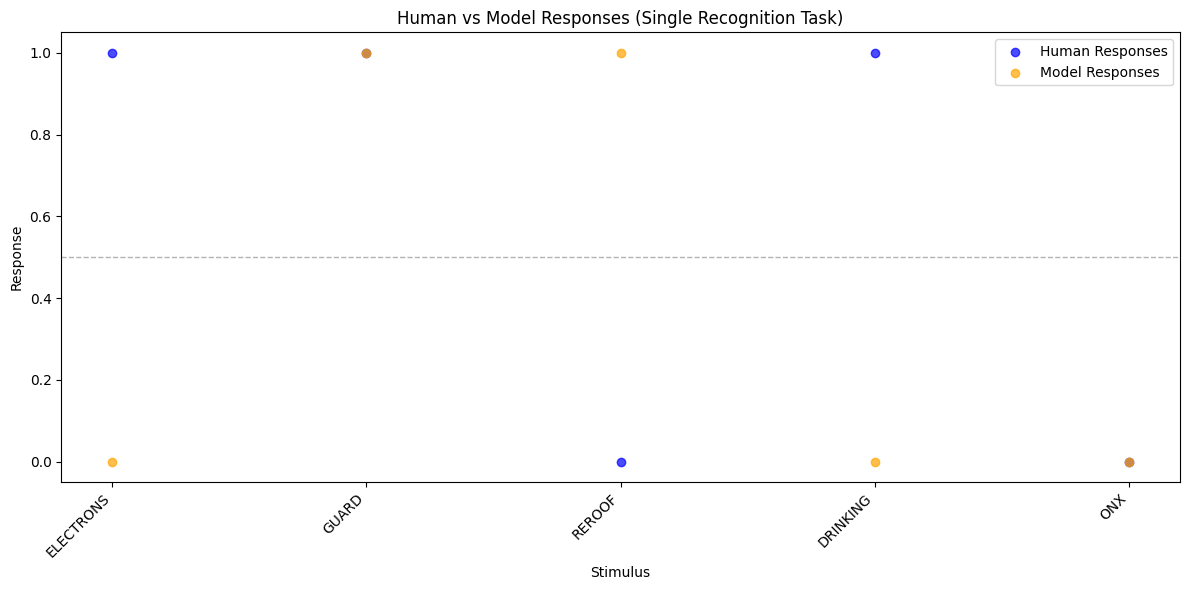

In [77]:
import matplotlib.pyplot as plt

data = {
    "Stimulus": test_items,
    "Human Response": human_responses,
    "Model Response": model_responses,
}


df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))


plt.scatter(df.index, df["Human Response"], label="Human Responses", color='blue', alpha=0.7)
plt.scatter(df.index, df["Model Response"], label="Model Responses", color='orange', alpha=0.7)


plt.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, alpha=0.6)  # Midline
plt.xticks(df.index, df["Stimulus"], rotation=45, ha="right")
plt.xlabel("Stimulus")
plt.ylabel("Response")
plt.title("Human vs Model Responses (Single Recognition Task)")
plt.legend()
plt.tight_layout()

# Show Plot
plt.show()
